In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)

01:54:32 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\dimot\.cmdstan\RTools40


CmdStan install directory: C:\Users\dimot\.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

In [2]:
op_sample = pd.read_csv("data/instacart/order_product_sample.csv")
o_sample = pd.read_csv("data/instacart/orders_sample.csv")
p_sample = pd.read_csv("data/instacart/products_sample.csv")

In [3]:
products = p_sample["product_id"].to_numpy()
orders = o_sample["order_id"].tolist()

n_products = len(products)
av0 = np.ones(n_products)

y = []
u = []
a = []

baskets = (
    op_sample
    .groupby("order_id")
    .agg({"product_id": list})
)

baskets.product_id = baskets.product_id.apply(lambda x: np.array(x))

order_to_basket = baskets.to_dict()["product_id"]
order_to_user = o_sample.groupby(["order_id"]).agg({"user_id":"first"}).to_dict()["user_id"]

for order in orders[0:1000]:
    basket = order_to_basket[order]
    item = basket[0]
    other = basket[1:]

    user = order_to_user[order]

    av = av0.copy()
    av[other-1] = 0

    y.append(item)
    u.append(user)
    a.append(av)

K = len(p_sample["product_id"].unique())
N = len(y)
U = len(o_sample.user_id.unique())

cmdstanpy.write_stan_json("stan_models/data.json", {"K":K, "N":N, "U":U, "y":y, "uu":u})

In [4]:
from cmdstanpy import CmdStanModel
import os

stan_model = CmdStanModel(stan_file=os.path.join("stan_models",'multinomial_logit.stan'), force_compile=True)

fit = stan_model.sample(
    data="stan_models/data.json",
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=12345#, show_console=True
)

01:55:35 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\multinomial_logit.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\multinomial_logit.exe
01:55:47 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\multinomial_logit.exe
01:55:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:04:41 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
param_summary = fit.summary()

In [22]:
param_summary.loc["u_alpha[1]":"u_alpha[10]"]

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
u_alpha[1],-0.023379,0.074523,5.04577,4.95809,-8.23995,0.044327,8.13835,4537.72,2815.92,0.999956
u_alpha[2],0.007868,0.073826,5.09773,5.22023,-8.40797,0.133647,8.21253,4815.97,2886.63,1.000470
u_alpha[3],-0.098416,0.069473,5.05943,5.02425,-8.29325,-0.117924,8.16219,5339.64,2775.42,1.001250
u_alpha[4],-0.038635,0.062415,5.03748,5.09103,-8.21872,-0.001939,8.20992,6433.37,2971.71,1.002020
u_alpha[5],-0.077231,0.069146,4.74783,4.69010,-7.91586,-0.097586,7.70797,4754.00,2763.85,1.003490
u_alpha[6],-0.015331,0.066825,4.97393,4.97787,-8.27360,0.012158,8.19278,5586.62,2773.07,0.999377
u_alpha[7],0.030025,0.071406,4.89274,4.87237,-7.93444,0.080379,7.95859,4735.29,2970.25,1.000240
u_alpha[8],-0.020090,0.077617,5.17444,5.16111,-8.35262,-0.050135,8.71098,4464.99,2723.02,1.000090
u_alpha[9],0.148045,0.066824,4.87772,4.93652,-7.87756,0.169533,8.00950,5370.03,3297.26,1.000800
u_alpha[10],-0.012971,0.066633,4.92181,4.83816,-8.19841,0.014459,8.26272,5481.37,2966.53,1.000570


In [ ]:
alpha = fit.stan_variable("alpha")
u_alpha = fit.stan_variable("u_alpha")

4000

In [7]:

df_alphas = pd.DataFrame(alpha)
df_ualpha = pd.DataFrame(u_alpha)
df_ualpha

,0,1,2,3,4,5,6,7,8,9
0,8.400420,-8.333460,0.457442,-4.476710,6.765230,5.345390,-6.310450,-9.852320,2.659140,3.267550
1,-4.002550,-1.726330,6.718530,7.033710,-5.684270,-5.436140,5.665350,-0.444813,-1.954850,0.054692
2,4.008320,1.628760,-8.436750,-7.680570,5.763790,7.122860,-4.178650,-0.975434,2.057800,-0.767428
3,0.145500,-0.179716,-14.516600,3.247390,3.198370,0.079756,0.194387,-0.848436,-2.409420,9.767920
4,-7.046630,2.290280,11.701700,-5.732520,-11.968800,4.738460,1.770280,-4.339710,3.581800,-7.583880
...,...,...,...,...,...,...,...,...,...,...
3995,1.277130,-7.123600,-5.385390,1.935940,0.173397,9.058080,-4.558540,-3.224360,1.381810,-5.368320
3996,-3.362000,7.200930,11.794300,-1.019270,-5.779250,-12.938000,-5.148300,3.098110,-1.445210,2.718560
3997,-0.503248,2.385020,12.154400,-0.243773,0.144333,1.726980,-1.857040,-3.520710,8.879790,1.850270
3998,6.092830,1.643780,3.322960,0.778771,-6.825960,-9.941740,-1.015820,-0.164199,-4.455900,-2.961430


C:\Users\dimot\AppData\Local\Temp\ipykernel_6780\1530867750.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Producto")


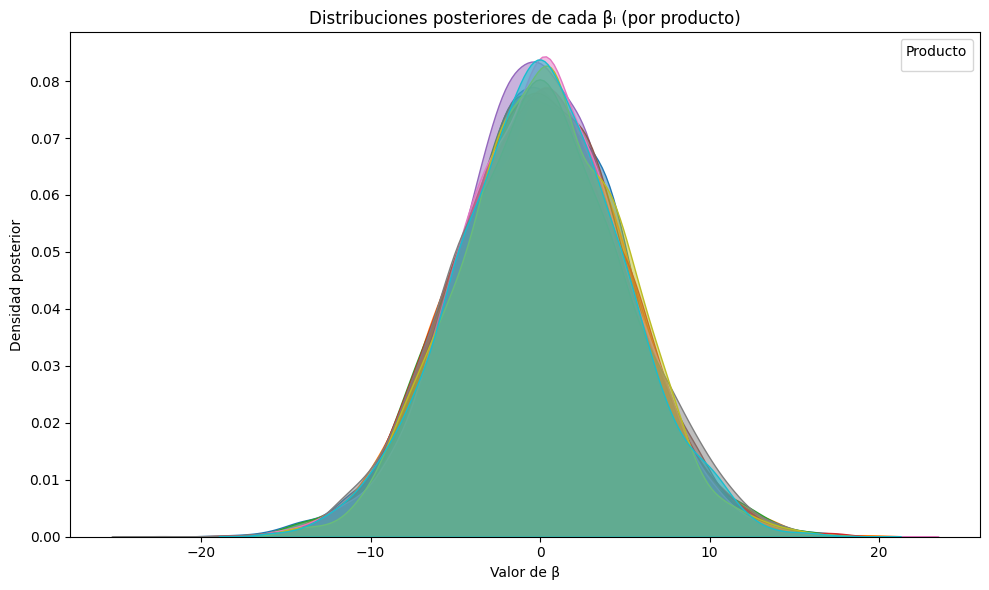

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(10):
    sns.kdeplot(
        data=df_ualpha,
        x=i,
        fill=True,
        common_norm=False,
        alpha=0.5
    )
plt.title("Distribuciones posteriores de cada βₗ (por producto)")
plt.xlabel("Valor de β")
plt.ylabel("Densidad posterior")
plt.legend(title="Producto")
plt.tight_layout()
plt.show()

In [ ]:
betas_array.shape

(4000, 4659, 1)